In [1]:
import textract
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scipy.spatial as scs
from sklearn.cluster import KMeans

In [2]:
#@title MPNet
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.spatial.distance import correlation
from scipy.spatial.distance import cosine
import src.embeddings
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

c:\Users\rogal\miniconda3\envs\Playing20QWithNature\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import src.extendedHierarchy

Import transcripts

In [4]:
import sys
sys.path.insert(1, 'C:/Users/rogal/Documents/GitHub/Playing20QWithNature/data/')

whole_text = textract.process("C:/Users/rogal/Documents/GitHub/Playing20QWithNature/data/transcripts.docx")
text = str(whole_text).split("\\n\\n")

Compute Question Embedding

In [5]:

all_questions_with_duplicates = src.embeddings.extract_questions(text)
all_questions = list(set(all_questions_with_duplicates))

model = SentenceTransformer('all-mpnet-base-v2')

def embed(input):
  return model.encode(input)

all_question_embeddings = embed(all_questions)
all_question_embeddings_with_duplicates = embed(all_questions_with_duplicates)

reduced_embeddings = TSNE(n_components=2, perplexity = 100, n_iter = 300000).fit_transform(all_question_embeddings)
#reduced_embeddings_3d = TSNE(n_components=3, perplexity = 100, n_iter = 300000 ).fit_transform(all_question_embeddings)

Dendrogram

Linkage

In [6]:
Z = hierarchy.linkage(all_question_embeddings, 'average', metric = src.embeddings.compute_similarity)
Z_with_duplicates = hierarchy.linkage(all_question_embeddings_with_duplicates, 'average', metric = src.embeddings.compute_similarity)

Dendrogram without Truncation

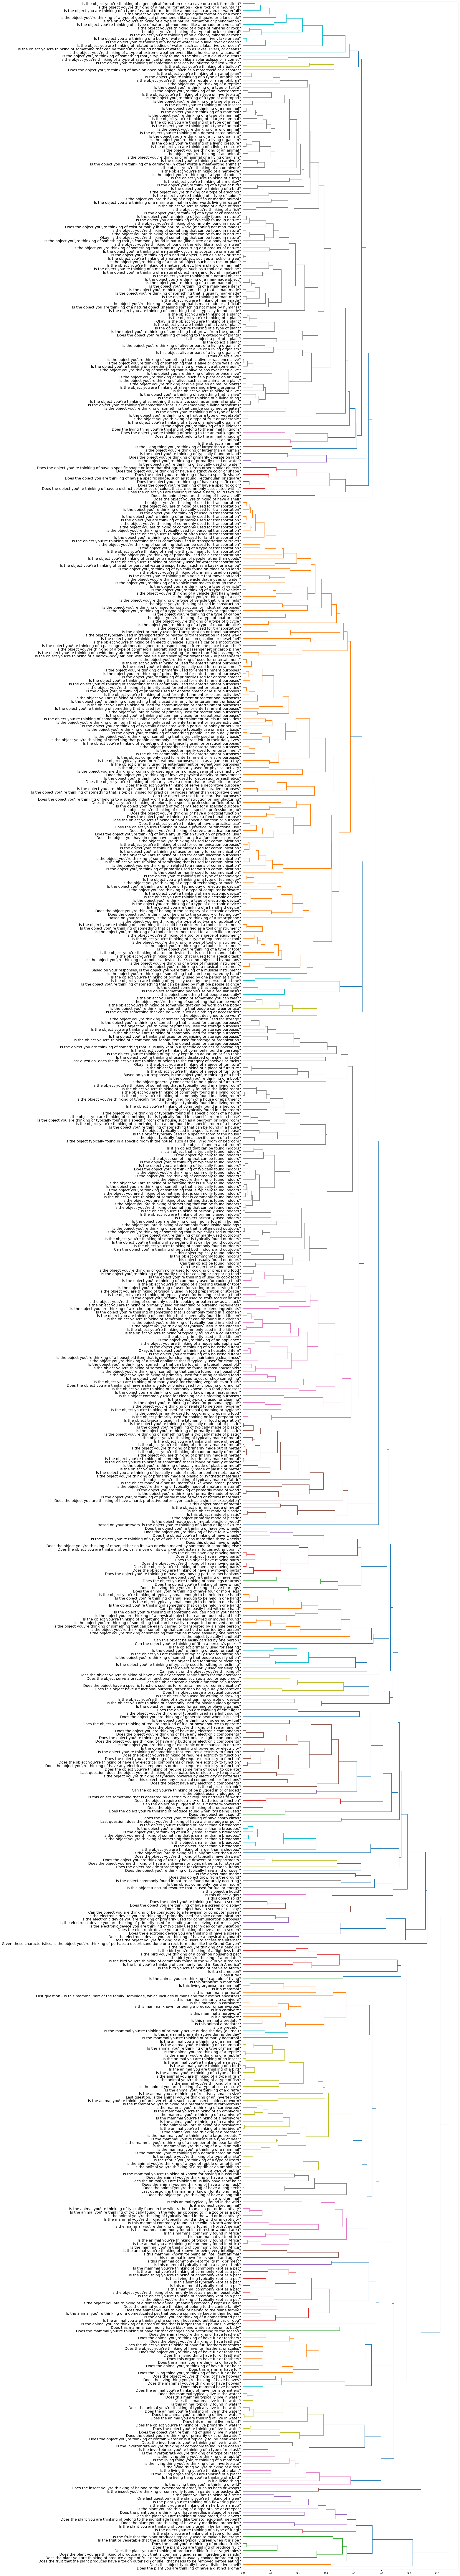

In [7]:
plt.figure(figsize = (15, 180))
 
src.extendedHierarchy.dendrogram(Z, orientation='right', labels=all_questions, leaf_font_size = 14, color_threshold= 0.4)
plt.show()

Dendrogram truncated at threshold 0.4 with cluster size limit

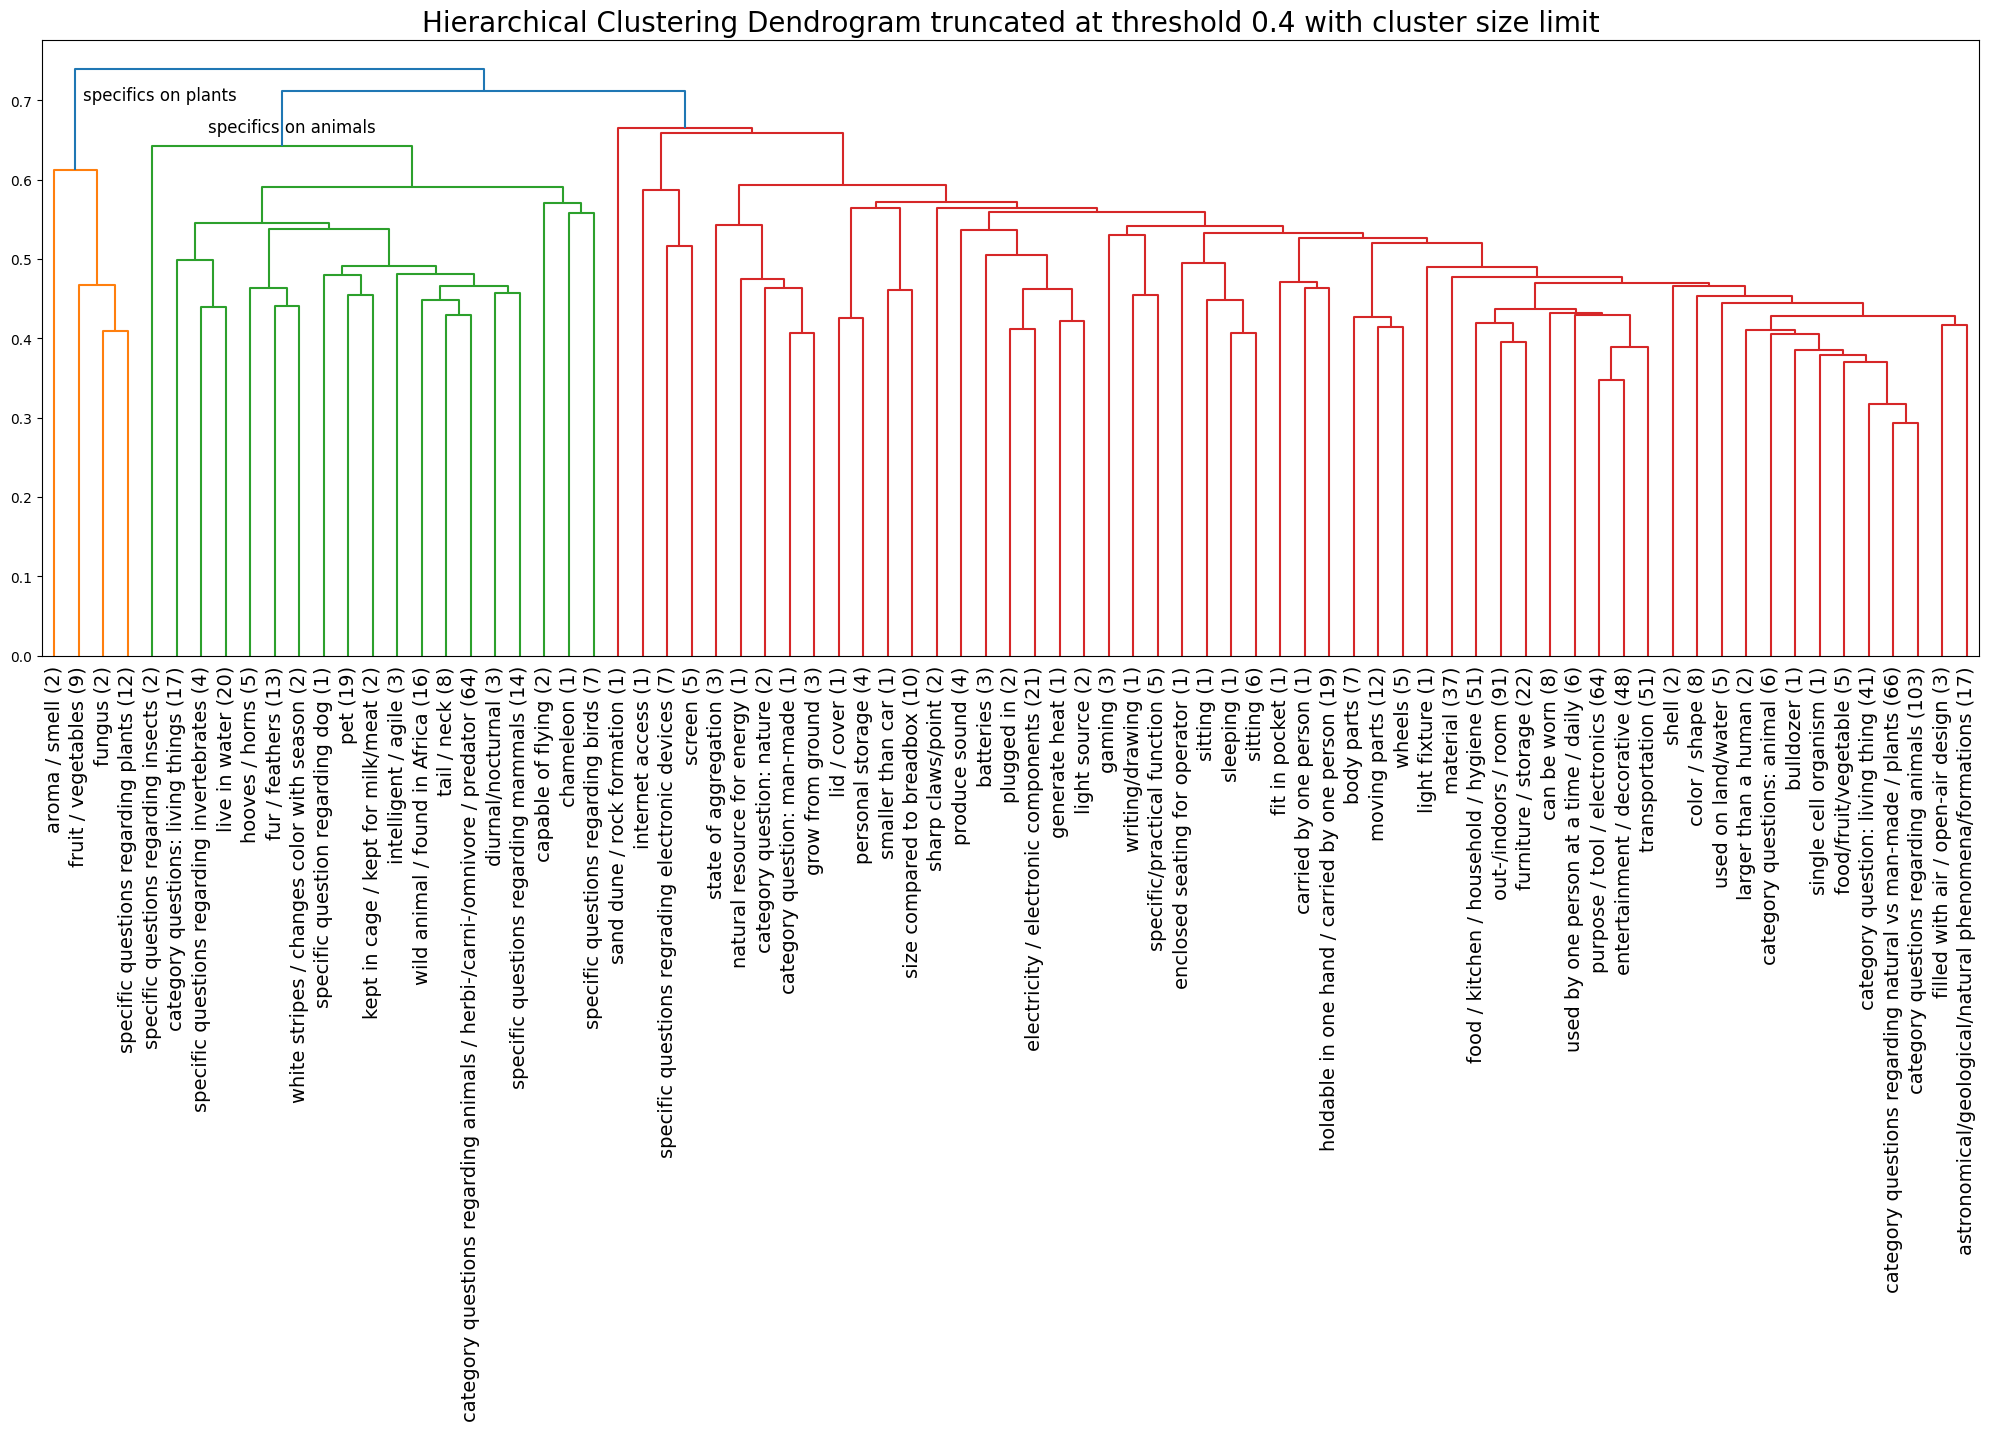

In [8]:
labels = ["aroma / smell", "fruit / vegetables", "fungus", "specific questions regarding plants", "specific questions regarding insects", "category questions: living things", "specific questions regarding invertebrates", "live in water", "hooves / horns", "fur / feathers", "white stripes / changes color with season", 
          "specific question regarding dog", "pet", "kept in cage / kept for milk/meat", "intelligent / agile", "wild animal / found in Africa", "tail / neck", "category questions regarding animals / herbi-/carni-/omnivore / predator", "diurnal/nocturnal", "specific questions regarding mammals", 
          "capable of flying", "chameleon", "specific questions regarding birds", "sand dune / rock formation", "internet access", "specific questions regrading electronic devices", "screen", "state of aggregation", "natural resource for energy", "category question: nature", "category question: man-made", "grow from ground", "lid / cover","personal storage",
          "smaller than car", "size compared to breadbox", "sharp claws/point", "produce sound", "batteries", "plugged in", "electricity / electronic components", "generate heat",
          "light source", "gaming", "writing/drawing", "specific/practical function", "enclosed seating for operator", "sitting", "sleeping", "sitting", "fit in pocket", "carried by one person", "holdable in one hand / carried by one person", "body parts", "moving parts", "wheels", "light fixture", "material",
          "food / kitchen / household / hygiene", "out-/indoors / room", "furniture / storage", "can be worn","used by one person at a time / daily", "purpose / tool / electronics", "entertainment / decorative", "transportation",
          "shell", "color / shape", "used on land/water","larger than a human", "category questions: animal", "bulldozer", "single cell organism", "food/fruit/vegetable", "category question: living thing","category questions regarding natural vs man-made / plants","category questions regarding animals", "filled with air / open-air design","astronomical/geological/natural phenomena/formations"]

plt.figure(figsize=(25, 8))

plt.title('Hierarchical Clustering Dendrogram truncated at threshold 0.4 with cluster size limit', fontsize=20)

#Z = hierarchy.linkage(allQuestionEmbeddings, 'average', metric = comp_sim)
R = src.extendedHierarchy.dendrogram(Z, leaf_font_size = 14, color_threshold= 0.7, truncate_mode = 'threshold',truncate_threshold= 0.4, labels = all_questions, no_plot=True, p=60) 

# create a label dictionary
leaves_with_label = R['leaves'][:len(labels)]
temp = {leaves_with_label[ii]: labels[ii] for ii in range(len(leaves_with_label))}


def llf_WoD(xx, count):
    c_temp = int(count)
    for t in R['truncated_leaves']: 
      if t[0] == xx:
        c_temp += all_questions_with_duplicates.count(t[1])-1
    count = str(c_temp)
    if xx in leaves_with_label:
      return "{}".format(temp[xx]) + " (" + count + ")"
    #in case not enough labels have been supplied
    else:
      return "other"

src.extendedHierarchy.dendrogram(Z, leaf_font_size = 14,  truncate_mode = 'threshold', leaf_label_func=llf_WoD, color_threshold = 0.7, truncate_threshold= 0.4, labels = all_questions, p = 60)
plt.text(17, 0.7, "specifics on plants", dict(fontsize = 12))
plt.text(68, 0.66, "specifics on animals", dict(fontsize = 12))
plt.show()

KMeans

In [9]:
wcss = []

for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, n_init = 'auto', max_iter=5000, random_state=42)
    kmeans.fit(reduced_embeddings)
    wcss.append(kmeans.inertia_)

# Prepare data for visualization:
wcss = pd.DataFrame(wcss, columns=['Value'])
wcss.index += 1

# Plot the elbow curve:
plot = px.line(wcss)
plot.update_layout(
    title={'text': "Within Cluster Sum of Squares or 'Elbow Chart'",
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5},
    xaxis_title='Clusters',
    yaxis_title='WCSS')
plot.update_layout(showlegend=False)
plot.show()

In [10]:
c = src.embeddings.cluster(20, reduced_embeddings)
labels = []
for i in c[1]:

  if i == 1:
    labels.append("sitting / can be worn / storage / holdable in hand")
  elif i == 2:
    labels.append("animal behaviour")
  elif i == 3:
    labels.append("material / wheels")
  elif i == 4:
    labels.append("house and furniture")
  elif i == 5:
    labels.append("transportation")
  elif i == 6:
    labels.append("purpose")
  elif i == 7:
    labels.append("living thing / plant")
  elif i == 8:
    labels.append("animal attributes")
  elif i == 9:
    labels.append("electricity/electronics")
  elif i == 10:
    labels.append("food / hygiene / storage")
  elif i == 11:
    labels.append("natural / man-made")
  elif i == 12:
    labels.append("indoors vs outdoors")
  elif i == 13:
    labels.append("type of lf and habitat")
  elif i == 14:
    labels.append("bodies of water / fish")
  elif i == 15:
    labels.append("communication / screen")
  elif i == 16:
    labels.append("size")
  elif i == 17:
    labels.append("body parts / moving parts / color/shape")
  elif i == 18:
    labels.append("tool")
  elif i == 19:
    labels.append("plant")
  else: 
    labels.append("type of animal / herbi/omni/carni")

dcm = {"sitting / can be worn / storage / holdable in hand": "darkgray", "animal behaviour": "red", "material / wheels": "darkseagreen", "house and furniture" : "darkblue", "transportation": " steelblue", 
       "purpose": "orchid", "living thing / plant" : "pink", "animal attributes": "olive", "electricity/electronics": "darkviolet", "food / hygiene / storage": "salmon", "natural / man-made": "orange", 
       "indoors vs outdoors": "gold", "type of lf and habitat": "firebrick", "bodies of water / fish": "darkturquoise", "communication / screen": "mediumvioletred", "size": "black", "body parts / moving parts / color/shape": "rosybrown", "tool": "yellowgreen", "plant": "hotpink", "type of animal / herbi/omni/carni": "burlywood"}
df_embeddings = pd.DataFrame(reduced_embeddings)
df_embeddings = df_embeddings.assign(text = all_questions)
df_embeddings = df_embeddings.assign(label= labels)

fig = px.scatter(df_embeddings, x = 0, y = 1, color='label', color_discrete_map = dcm, labels={'color': 'label'}, hover_data = ['text'] )

fig.show()

c:\Users\rogal\miniconda3\envs\Playing20QWithNature\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

